In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
def load_oil_production_data(excel_path):
    oil_output_df = pd.read_excel(excel_path, parse_dates=['Month'])
    oil_output_df.rename(columns={'Month': 'Date'}, inplace=True)
    oil_output_df['Date'] = [x.date() for x in oil_output_df['Date']]
    oil_output_df['Month'] = oil_output_df['Date'].astype(str).str[:7]
    return oil_output_df

def load_weather_data(odessa_path, san_antonio_path):
    odessa_weather = pd.read_csv(odessa_path, parse_dates=['datetime'])
    san_antonio_weather = pd.read_csv(san_antonio_path, parse_dates=['datetime'])

    odessa_weather['datetime'] = pd.to_datetime(odessa_weather['datetime'])
    san_antonio_weather['datetime'] = pd.to_datetime(san_antonio_weather['datetime'])

    odessa_weather['month'] = odessa_weather['datetime'].dt.to_period('M').astype(str)
    san_antonio_weather['month'] = san_antonio_weather['datetime'].dt.to_period('M').astype(str)

    features = [
        'cloudcover',
        'humidity',
        'solarradiation',
        'visibility',
        'precip',
        'snowdepth',
        'windspeed',
        'uvindex',
        'moonphase'
    ]

    # Group and average monthly weather features
    odessa_monthly = odessa_weather.groupby('month')[features].mean().add_suffix('_odessa').reset_index()
    san_antonio_monthly = san_antonio_weather.groupby('month')[features].mean().add_suffix('_sanantonio').reset_index()

    # Merge into a single monthly weather DataFrame
    merged_weather = pd.merge(odessa_monthly, san_antonio_monthly, on='month')
    return merged_weather


def load_dual_branch_data(permian_folder, eagleford_folder, oil_data, weather_data, transform):
    filenames = sorted(os.listdir(permian_folder))
    
    # Prepare lists to store image, weather features, and oil labels
    permian_imgs, eagleford_imgs = [], []
    odessa_weather, sanantonio_weather = [], []
    labels = []

    # Define the 9 weather features we want to extract for each region
    selected_odessa_features = [
        'cloudcover_odessa',
        'humidity_odessa',
        'solarradiation_odessa',
        'visibility_odessa',
        'precip_odessa',
        'snowdepth_odessa',
        'windspeed_odessa',
        'uvindex_odessa',
        'moonphase_odessa'
    ]

    selected_sanantonio_features = [
        'cloudcover_sanantonio',
        'humidity_sanantonio',
        'solarradiation_sanantonio',
        'visibility_sanantonio',
        'precip_sanantonio',
        'snowdepth_sanantonio',
        'windspeed_sanantonio',
        'uvindex_sanantonio',
        'moonphase_sanantonio'
    ]

    for filename in filenames:
        month = filename.split('.')[0]
        
        if month in oil_data['Month'].values and month in weather_data['month'].values:
            label = oil_data.loc[oil_data['Month'] == month, 'EIA Figure'].values[0]
            weather_row = weather_data[weather_data['month'] == month]

            # Load and convert images to grayscale
            permian_img = Image.open(os.path.join(permian_folder, filename)).convert('L')
            eagleford_img = Image.open(os.path.join(eagleford_folder, filename)).convert('L')

            if transform:
                permian_img = transform(permian_img)
                eagleford_img = transform(eagleford_img)

            permian_imgs.append(permian_img)
            eagleford_imgs.append(eagleford_img)
            labels.append(label)

            odessa_weather.append(torch.tensor(weather_row[selected_odessa_features].values[0], dtype=torch.float32))
            sanantonio_weather.append(torch.tensor(weather_row[selected_sanantonio_features].values[0], dtype=torch.float32))

    return (
        torch.stack(permian_imgs),
        torch.stack(eagleford_imgs),
        torch.stack(odessa_weather),
        torch.stack(sanantonio_weather),
        torch.tensor(labels, dtype=torch.float32)
    )

In [4]:
permian_folder = "Permian"
eagleford_folder = "Eagle_Ford"
oil_data_path = "EIA_Figure_TX_Million_Barrels.xlsx"
san_antonio_path = "san_antonio_weather_final.csv"
odessa_path = "odessa_weather_final.csv"

oil_data = load_oil_production_data(oil_data_path)
weather_data = load_weather_data(odessa_path, san_antonio_path)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load dataset
permian_imgs, eagleford_imgs, odessa_weather, sanantonio_weather, labels = load_dual_branch_data(
    permian_folder, eagleford_folder, oil_data, weather_data, transform
)
# Normalize labels
scaler = MinMaxScaler()
labels = torch.tensor(scaler.fit_transform(labels.reshape(-1, 1)).flatten(), dtype=torch.float32)

# Normalize Weather
weather_scaler_odessa = MinMaxScaler()
odessa_weather = torch.tensor(weather_scaler_odessa.fit_transform(odessa_weather), dtype=torch.float32)

weather_scaler_sanantonio = MinMaxScaler()
sanantonio_weather = torch.tensor(weather_scaler_sanantonio.fit_transform(sanantonio_weather), dtype=torch.float32)

# Create dataset
dataset = TensorDataset(
    permian_imgs,      
    eagleford_imgs,  
    odessa_weather,    
    sanantonio_weather,
    labels       
)

# Split data into training/testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
# Define CNN
class create_model(nn.Module):
    def __init__(self, weather_feature_dim_per_region):
        super(create_model, self).__init__()

        # CNN branch for Permian image + Odessa weather
        self.permian_features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # CNN branch for Eagle Ford image + San Antonio weather
        self.eagleford_features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifiers for each branch (image + weather combined)
        self.permian_classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16 + weather_feature_dim_per_region, 64),
            nn.ReLU()
        )

        self.eagleford_classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16 + weather_feature_dim_per_region, 64),
            nn.ReLU()
        )

        # Final regressor combining both outputs
        self.final_regressor = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, permian_img, eagleford_img, odessa_weather, sanantonio_weather):
        # Permian path
        permian_feat = self.permian_features(permian_img)
        permian_feat = permian_feat.view(permian_feat.size(0), -1)
        permian_combined = torch.cat((permian_feat, odessa_weather), dim=1)
        permian_output = self.permian_classifier(permian_combined)

        # Eagle Ford path
        eagleford_feat = self.eagleford_features(eagleford_img)
        eagleford_feat = eagleford_feat.view(eagleford_feat.size(0), -1)
        eagleford_combined = torch.cat((eagleford_feat, sanantonio_weather), dim=1)
        eagleford_output = self.eagleford_classifier(eagleford_combined)

        # Combine both regional outputs and predict
        combined = torch.cat((permian_output, eagleford_output), dim=1)
        return self.final_regressor(combined)


# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(weather_feature_dim_per_region=9).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for permian_img, eagleford_img, odessa_weather, sanantonio_weather, labels in train_loader:
        permian_img = permian_img.to(device)
        eagleford_img = eagleford_img.to(device)
        odessa_weather = odessa_weather.to(device)
        sanantonio_weather = sanantonio_weather.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(permian_img, eagleford_img, odessa_weather, sanantonio_weather).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for permian_img, eagleford_img, odessa_weather, sanantonio_weather, labels in test_loader:
            permian_img = permian_img.to(device)
            eagleford_img = eagleford_img.to(device)
            odessa_weather = odessa_weather.to(device)
            sanantonio_weather = sanantonio_weather.to(device)
            labels = labels.to(device)

            outputs = model(permian_img, eagleford_img, odessa_weather, sanantonio_weather).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")



Epoch 1/50, Train Loss: 0.4345, Val Loss: 0.2182
Epoch 2/50, Train Loss: 0.2020, Val Loss: 0.0601
Epoch 3/50, Train Loss: 0.0634, Val Loss: 0.0485
Epoch 4/50, Train Loss: 0.0462, Val Loss: 0.0510
Epoch 5/50, Train Loss: 0.0323, Val Loss: 0.0244
Epoch 6/50, Train Loss: 0.0284, Val Loss: 0.0238
Epoch 7/50, Train Loss: 0.0263, Val Loss: 0.0290
Epoch 8/50, Train Loss: 0.0223, Val Loss: 0.0182
Epoch 9/50, Train Loss: 0.0169, Val Loss: 0.0244
Epoch 10/50, Train Loss: 0.0208, Val Loss: 0.0147
Epoch 11/50, Train Loss: 0.0191, Val Loss: 0.0151
Epoch 12/50, Train Loss: 0.0132, Val Loss: 0.0147
Epoch 13/50, Train Loss: 0.0126, Val Loss: 0.0285
Epoch 14/50, Train Loss: 0.0169, Val Loss: 0.0097
Epoch 15/50, Train Loss: 0.0137, Val Loss: 0.0127
Epoch 16/50, Train Loss: 0.0130, Val Loss: 0.0098
Epoch 17/50, Train Loss: 0.0142, Val Loss: 0.0127
Epoch 18/50, Train Loss: 0.0079, Val Loss: 0.0115
Epoch 19/50, Train Loss: 0.0063, Val Loss: 0.0084
Epoch 20/50, Train Loss: 0.0057, Val Loss: 0.0077
Epoch 21/

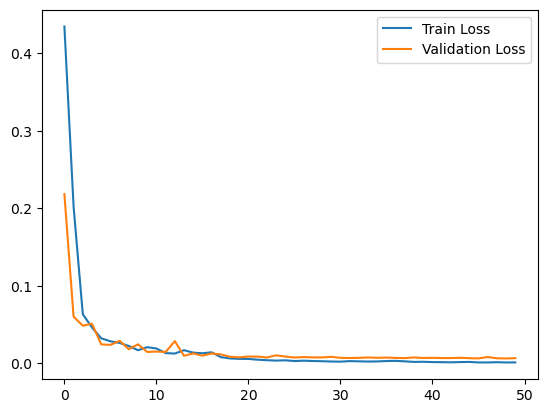

In [7]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), "cnn_oil_production_model.pth")